# Lab 2
Lucas Street, 1874989

In [32]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import pandas as pd
from scipy import stats, signal

## Problem 1

Let us assume the average number of cosmic background rays seen per day from a telescope is 4.5, and the average number of gamma rays per day emitted by a hypothetical source is 6.

In [33]:
avg_daily_cosmic_rays = 4.5
avg_daily_gamma_rays = 6

Let us also assume the cosmic background is Poisson-distributed; we can plot its probability mass function (PMF).

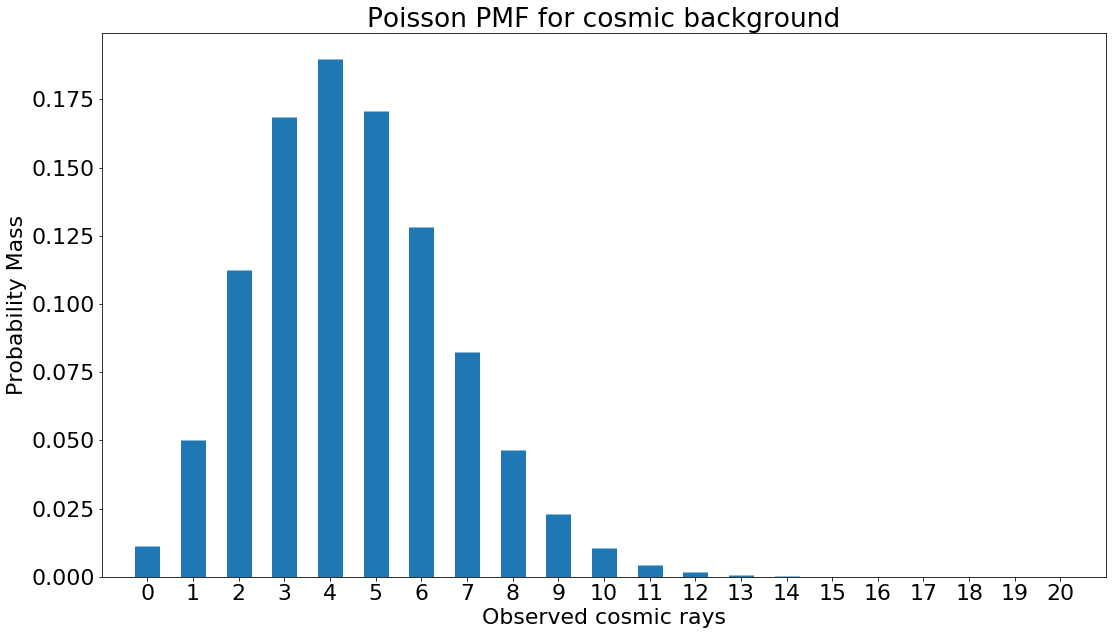

In [34]:
dist = stats.poisson(avg_daily_cosmic_rays)
x = np.arange(0, 21)
pmf = dist.pmf(x)

plt.title("Poisson PMF for cosmic background")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.vlines(x, 0, pmf, linewidth=25, color="C0")
plt.xticks(x)
plt.ylim(0, None);

To show how this distribution changes as we integrate for several days, we will plot the distribution corresponding to the expected number of cosmic rays seen after $n$ days. To do this, we convolve the distribution with itself for the given number of additional days.

In [35]:
def plot_sum(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(range(len(new_pmf)), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

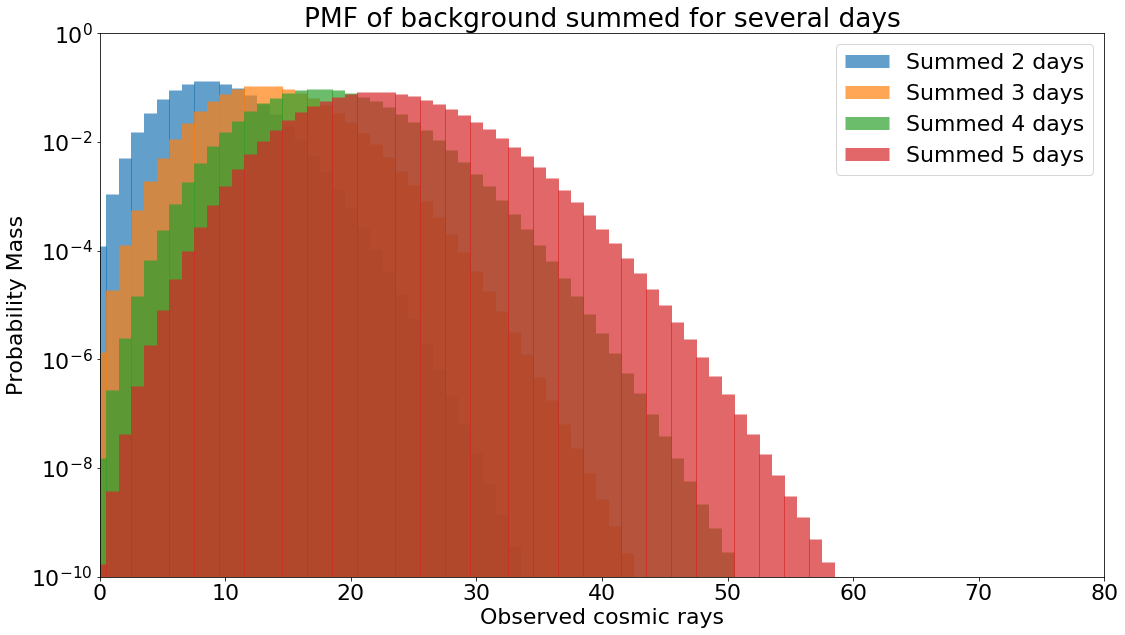

In [36]:
for i in range(1, 5):
    plot_sum(dist.pmf(x), i, linewidth=13, color=f"C{i - 1}", alpha=0.7)
plt.title("PMF of background summed for several days")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.legend([f"Summed {i + 1} days" for i in range(1, 5)])
plt.yscale('log')
plt.xlim(0, 80)
plt.ylim(1e-10, 1);

After integrating for 5 days, notice the distribution still has the characteristic "tail" on the right side that comes with a Poisson distribution. Conceptually, this makes sense: the Poisson distribution describes the independent probability of discrete events occurring over some time interval. In this case, integrating for 5 days will only add 5 of these independent variables together, so we still expect the distribution to retain a Poisson-like shape.

Mathematically, this makes sense because the convolution of multiple Poisson distributions is just the Poisson distribution with a mean equal to the sum of the $\lambda$'s of the distributions we're convolving. In other words, $\sum\limits_{i=1}^{n} Poisson(\lambda_i) = Poisson(\sum\limits_{i=1}^{n} \lambda_i)$ (Source: [Wikipedia](https://en.wikipedia.org/wiki/List_of_convolutions_of_probability_distributions)).

What if we _average_ the number of cosmic rays observed per day? For this, we convolve the distribution with itself $n$ times given $n$ additional days, and then divide the x-axis by $n + 1$, the total number of days.

In [37]:
def plot_average(pmf, n, *args, **kwargs):
    new_pmf = pmf
    for i in range(n):
        new_pmf = np.convolve(new_pmf, pmf)
    plt.vlines(np.arange(len(new_pmf)) / (n + 1), 0, new_pmf, *args, **kwargs)
    plt.xlim(0, None)
    plt.ylim(0, None)

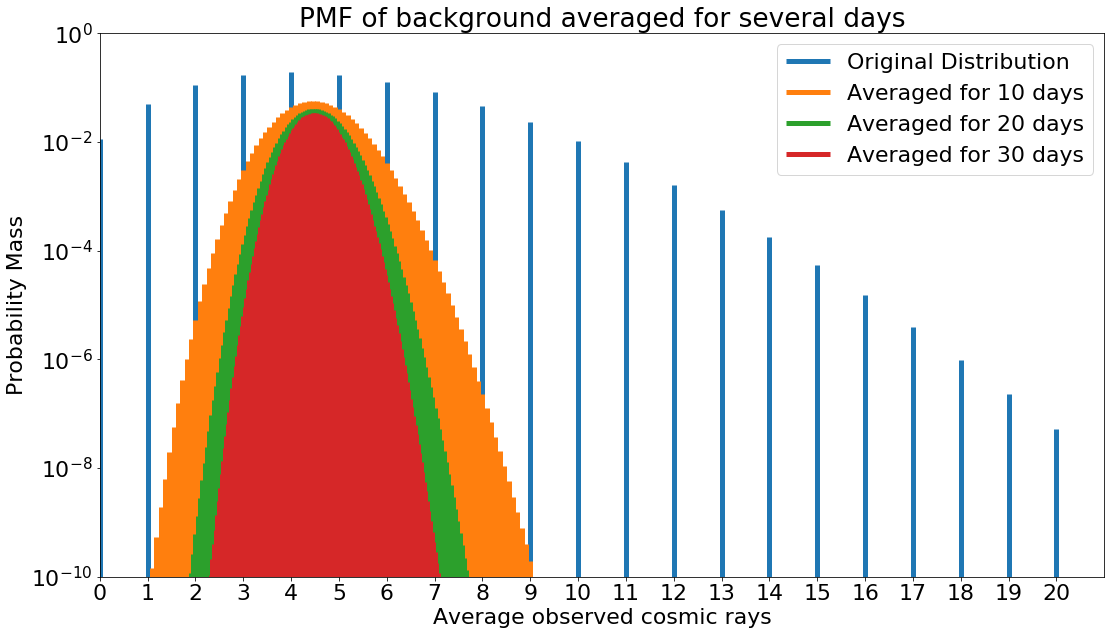

In [38]:
days = [0, 10, 20, 30]
for i in days:
    plot_average(pmf, i, linewidth=5, color=f"C{i // 10}")
plt.title("PMF of background averaged for several days")
plt.xlabel("Average observed cosmic rays")
plt.ylabel("Probability Mass")
plt.legend(['Original Distribution', *[f"Averaged for {n} days" for n in days[1:]]])
plt.yscale('log')
plt.xticks(range(0, 21))
plt.xlim(0, 21)
plt.ylim(1e-10, 1);

For larger $n$, the distribution shrinks and converges around its mean, into what looks like a Gaussian PDF. The downward parabolic shape on a log scale is characteristic of a Gaussian distribution. The shrinking makes sense, since the more we average, the more possible values there are for observing cosmic rays, and the probability masses are distributed out to each value accordingly.

What happens if we pick an even larger value of $n$, like 300 days?

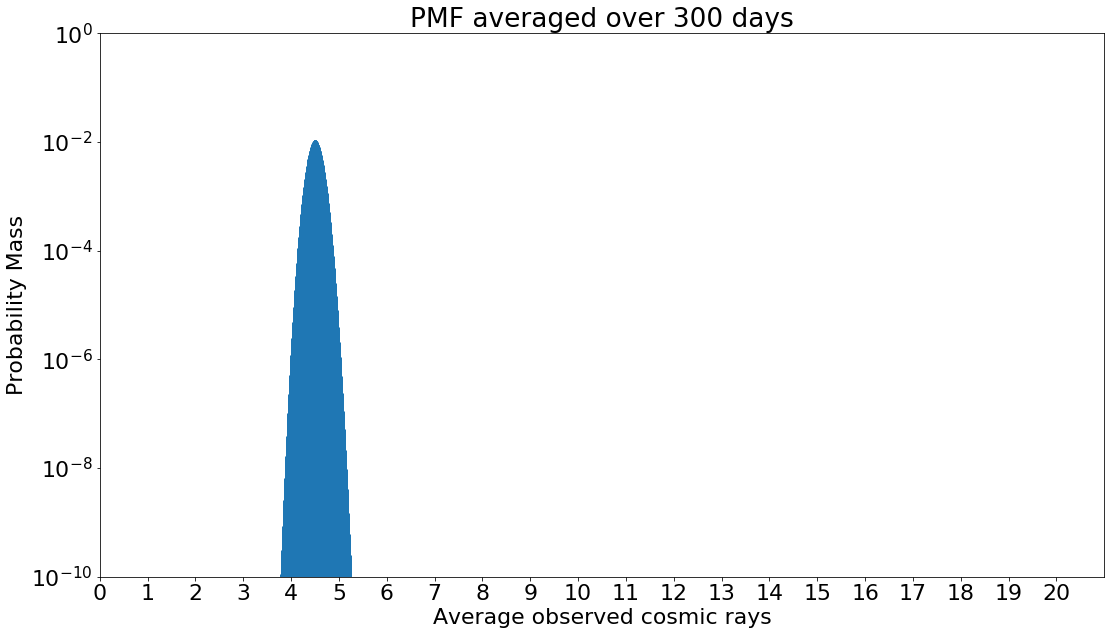

In [39]:
n = 300
plot_average(pmf, n, linewidth=1, color='C0')
plt.title(f"PMF averaged over {n} days")
plt.xlabel("Average observed cosmic rays")
plt.ylabel("Probability Mass")
plt.yscale('log')
plt.xticks(range(0, 21))
plt.xlim(0, 21)
plt.ylim(1e-10, 1);

Now it is much narrower and more Gaussian-shaped than Poisson-shaped, since it appears as a downward parabola on a log scale. The central limit theorem says that for some situations, repeated convolution of a distribution like we did above will eventually cause the distribution to converge to a Gaussian distribution. In relation to when we summed the distribution earlier, repeated summing for a large $n$ will also approximate a Gaussian distribution, since the limiting case of the Poisson distribution for large $\lambda$ is a Gaussian distribution too.

Let's choose to wait 10 days, and say we observe what appears to be 60 gamma rays (10 days * 6 gamma rays/day). What is the 'sigma' of this observation? That is, what is the probability that my cosmic ray background data gave me something that _looked_ like 60 or more gamma rays instead? The probability that we saw 60 or more cosmic rays in 10 days from the background is the integral of the PMF summed for 10 days, from 60 to infinity. It is simpler, however, to use the survival function, 1 minus the cumulative distribution function.

In [40]:
# Summed distribution has a mean of 10 * 4.5 = 45
# We're taking 1 - CDF, UP TO 60, not including 60, otherwise we'd lose the probability at 60 when taking 1 - CDF
prob = stats.poisson(45).sf(60 - 1)
print(prob)

0.018651134648575467


About 1.9%. Let's convert this to the form $X\sigma$ using the `ppf` function of the standard normal distribution.

In [41]:
stats.norm.ppf(1 - prob)

2.082440314519667

Therefore, the significance is $2.08\sigma$.

## Problem 2

Let's assume we have a new kind of measurement where our background has a skewed continuous distribution, like the Rayleigh distribution: $P(x) = \frac{x}{\sigma^2} e^{\frac{-x^2}{2\sigma^2}}$, where $\sigma$ is called the scale parameter. Let's set $\sigma = 1$ and plot the PDF of the distribution.

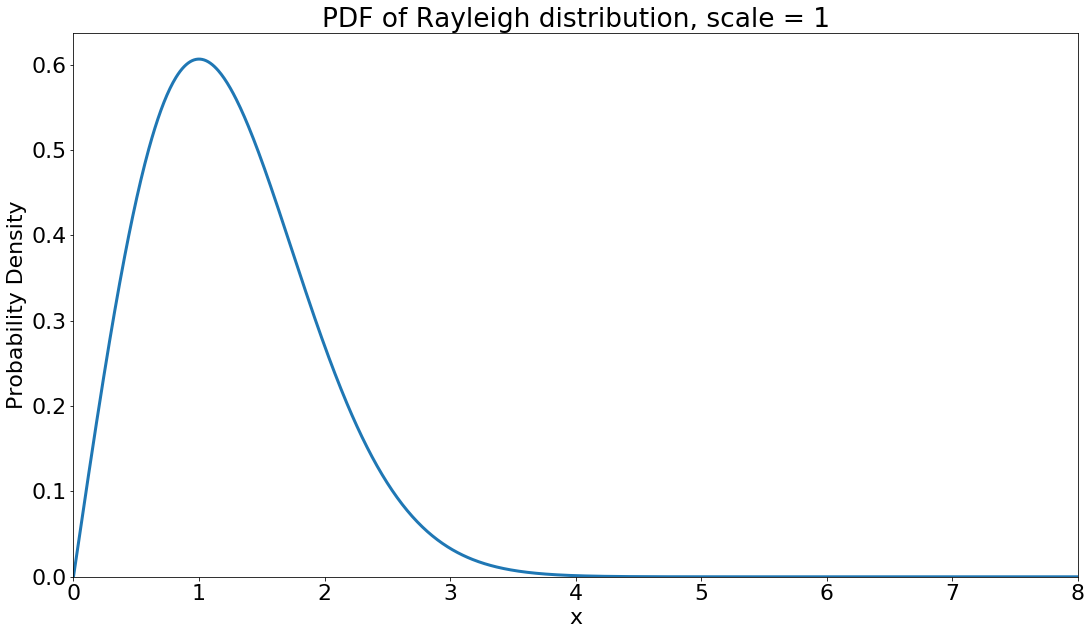

In [42]:
scale = 1
dist = stats.rayleigh(scale=scale)
x = np.linspace(0, 8, 1000)
plt.title(f"PDF of Rayleigh distribution, scale = {scale}")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.plot(x, dist.pdf(x), linewidth=3)
plt.xlim(0, 8)
plt.xticks(range(0, 9))
plt.ylim(0, None);

Now let's average over more observing intervals by convolving the distribution with itself, just as we did before with the Poisson distribution.

In [43]:
def plot_average_rayleigh(x, pdf, n, *args, **kwargs):
    new_pdf = pdf
    for i in range(n):
        new_pdf = np.convolve(new_pdf, pdf)
    plt.plot(np.linspace(x[0], x[-1], len(new_pdf)), new_pdf, *args, **kwargs)
    plt.xlim(x[0], x[-1])

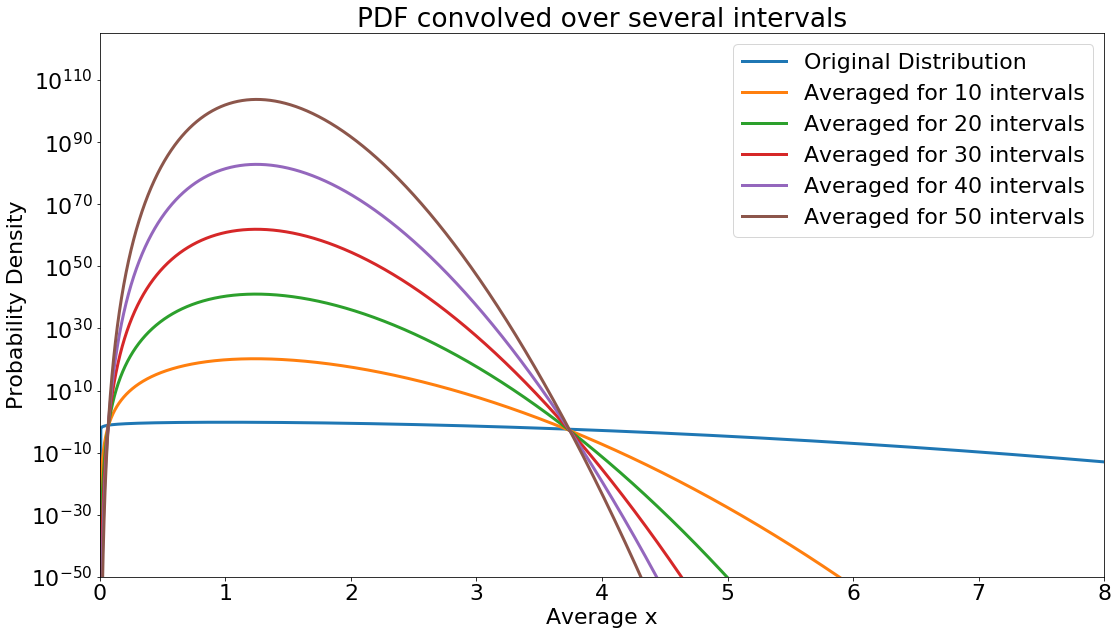

In [44]:
pdf = dist.pdf(x)
nums = [0, 10, 20, 30, 40, 50]
for i in nums:
    plot_average_rayleigh(x, pdf, i, linewidth=3)
plt.title("PDF convolved over several intervals")
plt.xlabel("Average x")
plt.ylabel("Probability Density")
plt.yscale('log')
plt.ylim(1e-50, None);
plt.legend(['Original Distribution', *[f"Averaged for {n} intervals" for n in nums[1:]]]);

The shapes of the distributions get taller and narrower, but they still have that "Rayleigh tail" on the right side of the peak. Because each PDF does not appear as a downward parabola on the log scale, they don't look Gaussian yet. What happens if we try a larger number of convolutions, say, 200?

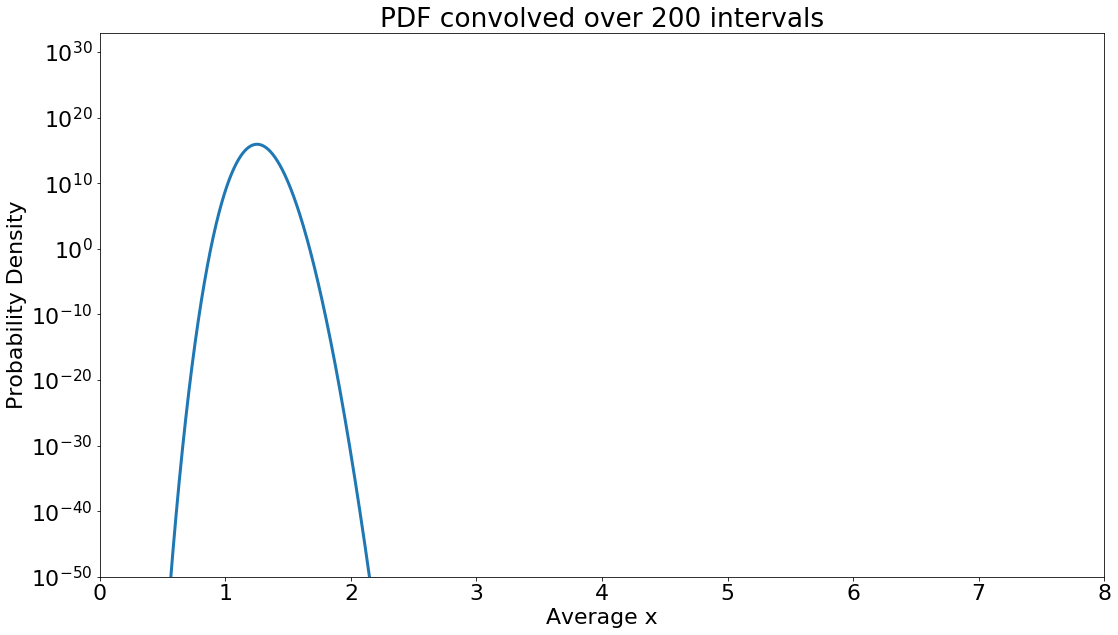

In [45]:
n = 200
# Divide original PDF by 100 in order to not melt my computer
plot_average_rayleigh(x, pdf / 100, n, linewidth=3)
plt.title(f"PDF convolved over {n} intervals")
plt.xlabel("Average x")
plt.ylabel("Probability Density")
plt.yscale('log')
plt.xlim(0, 8)
plt.ylim(1e-50, None);

After convolving it over 200 intervals, it has begun to look parabolic on a log scale, indicating that it has approached an approximately Gaussian distribution. Note that I had to scale down the original PDF by 100 times just to be able to fit the plot on screen without causing a meltdown due to numeric overflow. The shape of the distribution, however, should be unaffected.

## Problem 3

### Version 1

_You have an alert from LIGO that is also seen in with the X-ray/ultra-violet satellite SWIFT. SWIFT gives you a very precise location, so you take an image of that part of the sky. But because of SWIFT's accuracy, you know which pixel in your image to look for a counterpart in._

Our thermal noise background is Gaussian distributed with a mean of 0 and with constant width over the image. Let's say by examining all the other pixels in our image, we find the width of the background distribution to be 3 brightness units. Let's plot the PDF of the background for the one pixel corresponding to the location given by SWIFT.

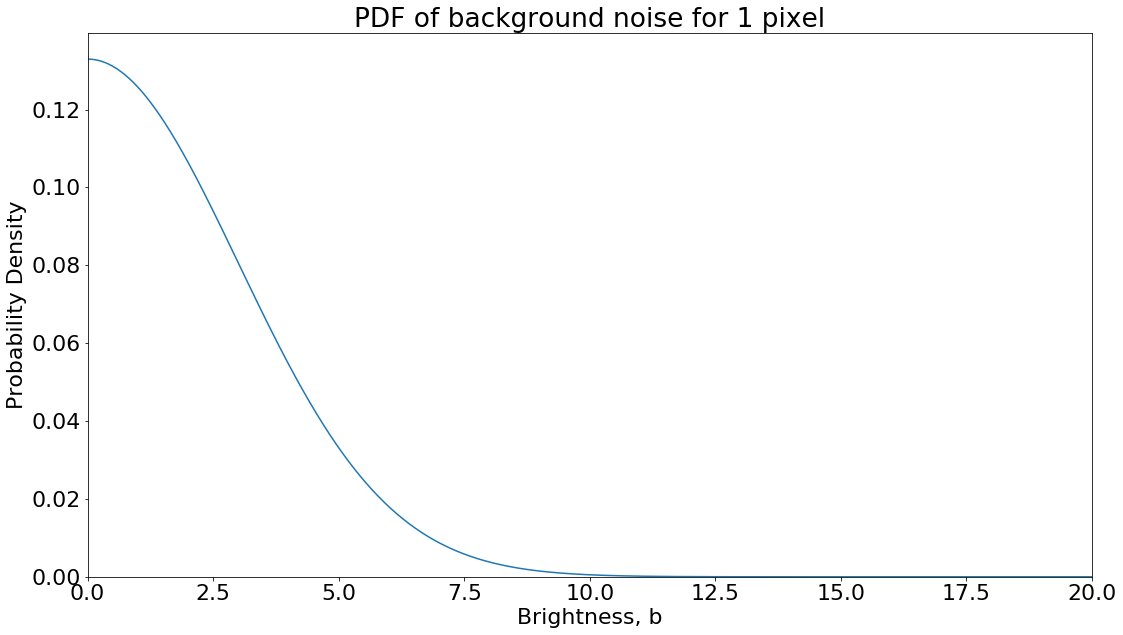

In [46]:
dist = stats.norm(scale=3)

x = np.linspace(0, 20, 1000)
plt.title("PDF of background noise for 1 pixel")
plt.xlabel("Brightness, b")
plt.ylabel("Probability Density")
plt.plot(x, dist.pdf(x))
plt.xlim(0, 20)
plt.ylim(0, None);

Now let's assume I see a signal of strength 18.2 brightness units on this pixel. What is the significance of this result? Note that, in physics, a significance of $5\sigma$ is enough to indicate a rejection of the null hypothesis. The statistical question we'd like to ask here is: What is the probability that the signal-free background data of 1 pixel produced a measurement that is as signal-like or more signal-like than 18.2 units?

To answer this question, we integrate the PDF of the background noise distribution for 1 pixel from 18.2 to $\infty$: $P(b \geq 18.2) = \int\limits_{18.2}^{\infty} \frac{1}{\sqrt{18\pi}} e^{\frac{-x^2}{18}}$

Let's use the survival function to calculate this value.

In [47]:
prob = dist.sf(18.2)
print(prob)

6.529609989961205e-10


A very small probability. Let's convert it to the form $X\sigma$.

In [48]:
stats.norm.ppf(1 - prob)

6.06666666184555

The significance of our result is $6.07\sigma$. This is greater than $5\sigma$, so we can reject our null hypothesis and claim a discovery!

### Version 2

_You have an alert from LIGO, but no associated detection from SWIFT. This could be because it is a black hole-black hole merger, a black hole-neutron star merger (neither seem to emit X-rays or UV light), or it could because SWIFT was indisposed at the time (wrong side of the earth in its orbit). Whatever the cause, you know what region of the sky to look in, but not which pixel._

Let's perform the same analysis, but this time without the location data from SWIFT. If we're searching for a signal in 10,000 pixels, we need to combine the background distribution of all 10,000 pixels - because we "look elsewhere" to other pixels if we don't see a signal-like brightness on one pixel, the PDFs for all the pixels we check must be combined (see the ["look-elsewhere effect"](https://en.wikipedia.org/wiki/Look-elsewhere_effect)). We do this by multiplying the background distribution for one pixel by 10,000.

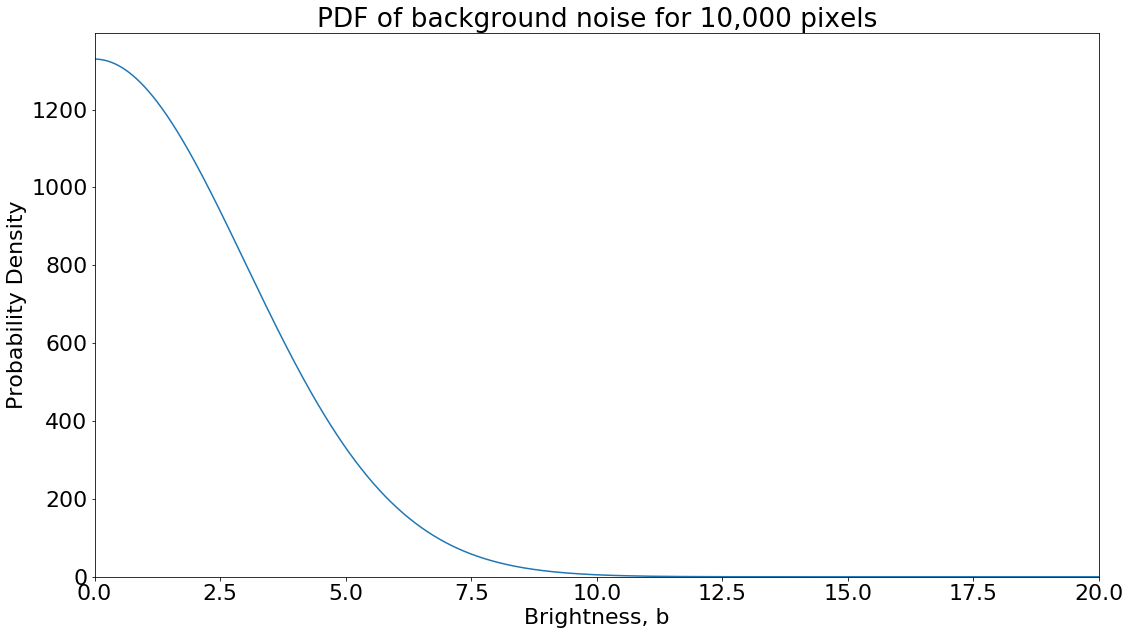

In [49]:
dist = stats.norm(scale=3)

x = np.linspace(0, 20, 1000)
plt.title("PDF of background noise for 10,000 pixels")
plt.xlabel("Brightness, b")
plt.ylabel("Probability Density")
plt.plot(x, 10_000 * dist.pdf(x))
plt.xlim(0, 20)
plt.ylim(0, None);

Notice how the height of the PDF has increased substantially.

Now let's pick the brightest candidate signal (b = 18.2 again) and find the significance of this measurement. Note that the statistical question we are asking is slightly different than before: What is the probability that the _total_ signal-free background data _of 10,000 pixels_ produced a measurement that is as signal-like or more signal-like than 18.2?

To answer this question, we integrate the PDF of the total background distribution for 10,000 pixels from 18.2 to $\infty$: $P(b \geq 18.2) = \int\limits_{18.2}^{\infty} \frac{10,000}{\sqrt{18\pi}} e^{\frac{-x^2}{18}}$

Let's use the survival function to calculate this value.

In [50]:
# Factor of 10,000 is pulled out of the integral
prob = 10_000 * dist.sf(18.2)
print(prob)

6.529609989961204e-06


Converting to the form $X\sigma$ gives:

In [51]:
stats.norm.ppf(1 - prob)

4.359110439651986

This is now less than $5\sigma$, so we can no longer reject the null hypothesis. We compensated for the look-elsewhere effect by multiplying the probability of getting a false signal from the background by 10,000, the number of "trials" performed.

### Problem 4

Now let's do the previous problem, but a little differently - we're going to work backwards. Assuming the same background distribution as in problem 3, what is the signal required for a $5\sigma$ detection in the case of 1 pixel?

First, we get the probability corresponding to $5\sigma$:

In [52]:
prob = stats.norm.sf(5)
print(prob)

2.866515718791933e-07


Now we want the point $b$ for which, when integrating the background distribution from $b$ to $\infty$, gives us the probability associated with $5\sigma$. We can use the `ppf` function from our background distribution:

In [53]:
# Recall PPF finds the point at which the CDF matches the given probability, so take 1 - prob.
thres_1 = dist.ppf(1 - prob)
print(thres_1)

14.999999999910528


So a $5\sigma$ detection would require a signal threshold of about 15.0. 

How about the signal threshold needed for a $5\sigma$ detection in our background noise distribution for 10,000 pixels?

In [54]:
# Divide by 10,000 here, since we multiply by 10,000 when evaluating the integral in version 2
new_prob = prob / 10_000
thres_2 = dist.ppf(1 - new_prob)
print(thres_2)

19.651612460674965


In [55]:
print(thres_2 / thres_1)

1.3101074973861455


So our required signal threshold increases to 19.7 units. In other words, our signal must be about 31% brighter with 10,000 pixels in order to consider it a discovery.

This might seem a little lenient. _Only_ 31% brighter? What are the chances of seeing a signal at least that bright compared to our original threshold?

In [56]:
# Factors of 10,000 cancel here
dist.sf(thres_2) / dist.sf(thres_1)

0.00010000008423938025

We didn't even need to calculate this - of course it's a 1 in 10,000 chance! It might seem like the sensitivity penalty is low, but it is compensated by the large decrease in probability of seeing a signal at or above the slightly increased threshold.

Let's examine the effect on the required threshold if we increase our trials factor by several orders of magnitude.

In [57]:
n = 10e6 # trials factor of 10,000,000
new_prob = prob / n
thres_3 = dist.ppf(1 - new_prob)
print(thres_3)

22.542411418261633


In [58]:
print(thres_3 / thres_1)

1.5028274278930729


With 10,000,000 trials, we need a signal about 50% brighter than our original signal in order to consider it a discovery. This is, of course, a 1 in 10,000,000 chance - the signal threshold barely changes because the likelihood of seeing such a signal drops _dramatically_ as we travel further from the mean of our distribution.

### Extra Credit

With a non-Gaussian distribution, say, a skewed one with a long tail extending to the right, the effect on our required signal threshold would be smaller as the trials factor increased. Because the height of the tail of the skewed distribution is large relative to the height of a Gaussian tail, it would take a smaller increase in the signal threshold to match the same decrease in probability, since the area under the skewed distribution's tail is larger when the trials factor is larger.

For example, consider a Rayleigh-distributed background of $\sigma=2$.

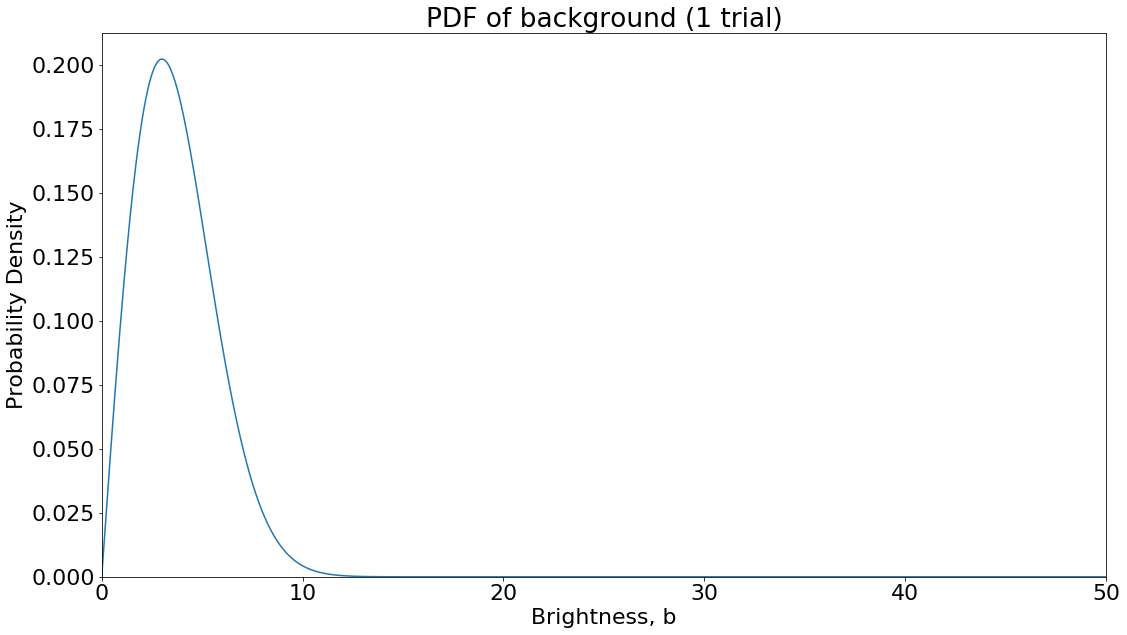

In [59]:
dist = stats.rayleigh(scale=3)

x = np.linspace(0, 50, 1000)
plt.title("PDF of background (1 trial)")
plt.xlabel("Brightness, b")
plt.ylabel("Probability Density")
plt.plot(x, dist.pdf(x))
plt.xlim(0, 50)
plt.ylim(1e-20, None);

The signal threshold required for a $5\sigma$ discovery is then

In [60]:
thres_1 = dist.ppf(1 - prob)
print(thres_1)

16.467239328102714


And the threshold required for a $5\sigma$ discovery with 10,000 trials is

In [61]:
thres_2 = dist.ppf(1 - prob / 10_000)
print(thres_2)

20.90349450741435


In [62]:
print(thres_2 / thres_1)

1.2693988403836942


A threshold increase of only 26.9%, as opposed to 31% in the Gaussian case. Thus, for a Rayleigh-distributed background, the sensitivity penalty we found is smaller with a larger trials factor compared to the Gaussian-distributed background.